# Supermarket Inventory Management with Pi_Optimal

## Introduction

This notebook demonstrates how to use `pi_optimal` to optimize inventory management decisions in a supermarket setting, with a focus on **minimizing waste** while maintaining profitability. We'll work with perishable products like fresh produce, dairy, and bakery items, which have different shelf lives and demand patterns.

The key challenge in supermarket inventory management is balancing:
- **Stockouts**: Not having enough inventory leads to lost sales and unhappy customers
- **Waste**: Ordering too much leads to expired products and financial losses
- **Holding Costs**: Maintaining inventory incurs costs (refrigeration, space, handling)

Through this notebook, we'll explore how reinforcement learning with `pi_optimal` can help find optimal ordering strategies to address these challenges.

---
## Table of Contents

1. [Setup and Configuration](#setup-and-configuration)
2. [Data Collection](#data-collection)
   - [Simulating Random Ordering Strategies](#simulating-random-ordering-strategies)
   - [Exploring Collected Data](#exploring-collected-data)
3. [Defining Custom Reward Functions](#defining-custom-reward-functions)
   - [Profit-Oriented Reward](#profit-oriented-reward)
   - [Example Reward Functions](#example-reward-functions)
4. [Training with Pi_Optimal](#training-with-pi_optimal)
   - [Dataset Preparation](#dataset-preparation)
   - [Agent Configuration](#agent-configuration)
   - [Training the Agent](#training-the-agent)
5. [Evaluating Performance](#evaluating-performance)
   - [Policy Visualization](#policy-visualization)
   - [Testing in Environment](#testing-in-environment)
   - [Comparative Analysis](#comparative-analysis)
6. [Conclusion](#conclusion)
7. [Next Steps](#next-steps)
---

## Setup and Configuration

First, let's import the necessary libraries and load our supermarket environment.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import pi_optimal as po
from supermarket_env import SupermarketEnv, MultiProductSupermarketEnv

# Set plotting style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

In [2]:
# Create a single-product supermarket environment with default settings
single_product_env = SupermarketEnv()

# Create a multi-product supermarket environment with default settings
multi_product_env = MultiProductSupermarketEnv()

# Print the product names in the multi-product environment
print(f"Products available in the multi-product environment: {multi_product_env.product_names}")

Products available in the multi-product environment: ['bakery', 'dairy', 'fresh_produce']


For simplicity in this notebook, we'll focus on the single-product environment, but the approach can be extended to the multi-product environment as well.

## Data Collection

To train our RL agent, we first need to collect data on different ordering strategies. We'll use random ordering strategies to explore the state and action space.

### Simulating Random Ordering Strategies

Let's simulate multiple episodes with different random ordering strategies to collect data.

In [3]:
def collect_data(env, n_episodes=50, max_steps=30, ordering_strategies=None, random_seed=42):
    """
    Collect data by running multiple episodes with different ordering strategies.
    
    Args:
        env: The environment to simulate
        n_episodes: Number of episodes to simulate
        max_steps: Maximum steps per episode
        ordering_strategies: List of functions that take (observation, info) and return an action
                            If None, random strategies will be used
        random_seed: Seed for reproducibility
        
    Returns:
        DataFrame with collected data
    """
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # Create default random strategies if none provided
    if ordering_strategies is None:
        # Strategy 1: Order randomly between 0 and 20
        def random_small_order(obs, info):
            return np.array([np.random.randint(0, 21)])
        
        # Strategy 2: Order randomly between 10 and 30
        def random_medium_order(obs, info):
            return np.array([np.random.randint(10, 31)])
        
        # Strategy 3: Order randomly between 20 and 40
        def random_large_order(obs, info):
            return np.array([np.random.randint(20, 41)])
        
        # Strategy 4: Order based on current inventory (replenish to target)
        def replenish_to_target(obs, info, target=30):
            current_inventory = np.sum(obs['inventory'])
            order = max(0, target - current_inventory)
            return np.array([order])
        
        # Strategy 5: Order based on recent demand
        def order_based_on_demand(obs, info):
            # Calculate average of recent demand and add a safety stock
            avg_demand = np.mean(obs['demand_history'])
            safety_stock = 5
            return np.array([avg_demand + safety_stock])
        
        ordering_strategies = [
            random_small_order,
            random_medium_order,
            random_large_order,
            replenish_to_target,
            order_based_on_demand
        ]
    
    all_episodes_data = []
    
    for episode in range(n_episodes):
        # Randomly select a strategy for this episode
        strategy = np.random.choice(ordering_strategies)
        strategy_name = strategy.__name__
        
        # Reset the environment
        observation, info = env.reset(seed=random_seed + episode)
        
        for step in range(max_steps):
            # Determine action based on selected strategy
            action = strategy(observation, info)
            
            # Take step in environment
            observation, reward, terminated, truncated, info = env.step(action)
            
            if terminated or truncated:
                break
        
        # Retrieve episode history from the environment
        episode_df = env.get_episode_history()
        
        # Add episode and strategy identifiers
        episode_df['episode'] = episode
        episode_df['strategy'] = strategy_name
        
        # Add to collection
        all_episodes_data.append(episode_df)
    
    # Combine all episodes into a single DataFrame
    combined_df = pd.concat(all_episodes_data, ignore_index=True)
    
    return combined_df

In [4]:
# Collect data from the single-product environment
train_df = collect_data(single_product_env, n_episodes=50, max_steps=30)
test_data = collect_data(single_product_env, n_episodes=1, max_steps=20)

# Display the first few rows
train_df.head()

,day,day_of_week,demand,order_quantity,inventory_before_order,inventory_after_order,inventory_after_demand,sales,waste,stockouts,revenue,purchase_cost,holding_cost,stockout_cost,waste_cost,profit,total_inventory,episode,strategy
0,0,0,12,20,10,30,18,12,0,0,30.0,20.0,1.8,0.0,0.0,8.2,18,0,replenish_to_target
1,1,1,17,12,18,30,13,17,0,0,42.5,12.0,1.3,0.0,0.0,29.2,13,0,replenish_to_target
2,2,2,21,17,13,30,9,21,0,0,52.5,17.0,0.9,0.0,0.0,34.6,9,0,replenish_to_target
3,3,3,2,21,9,30,28,2,0,0,5.0,21.0,2.8,0.0,0.0,-18.8,28,0,replenish_to_target
4,4,4,21,2,28,30,9,21,0,0,52.5,2.0,0.9,0.0,0.0,49.6,9,0,replenish_to_target


### Exploring Collected Data

Let's visualize some key metrics from our collected data to understand the tradeoffs different ordering strategies make.

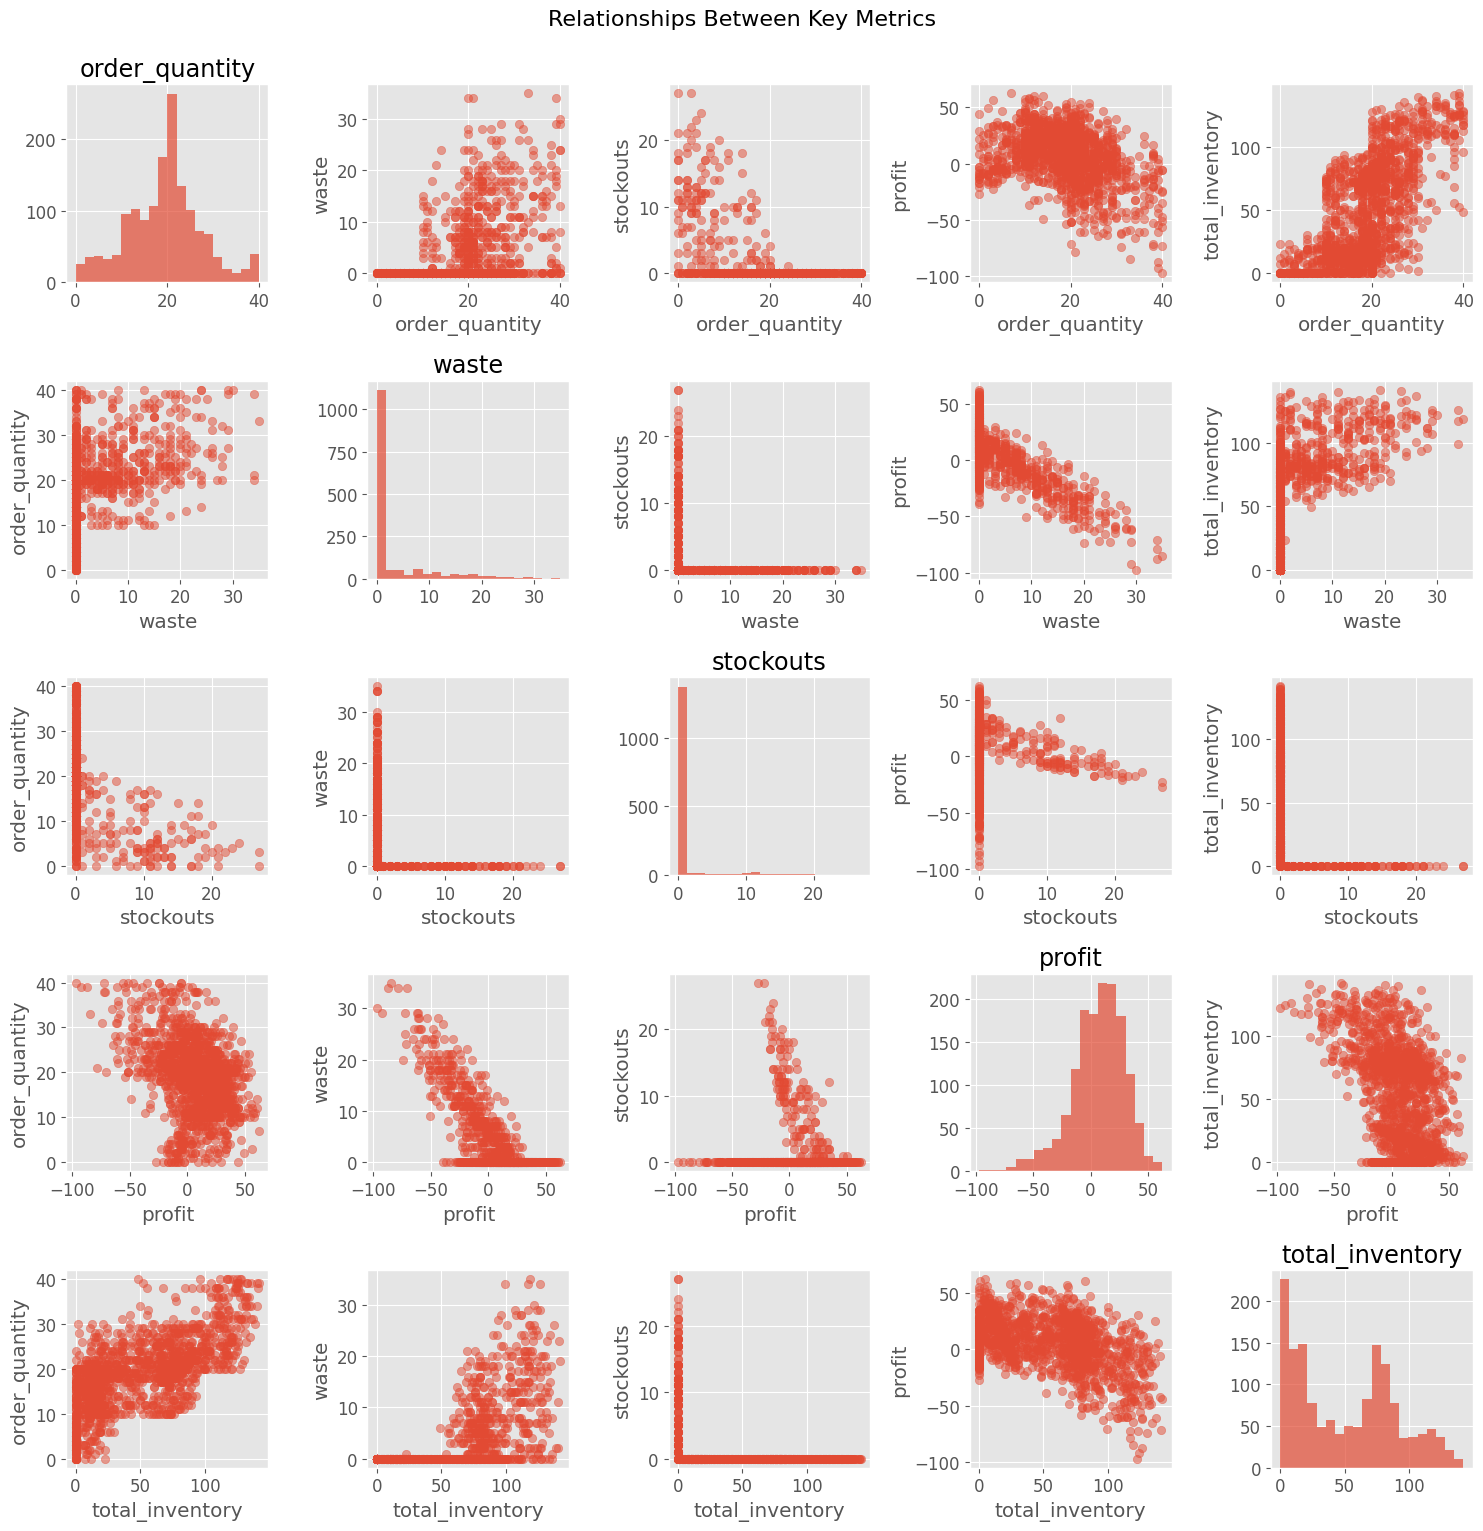

In [5]:
# Create pair plots to visualize relationships between key metrics using matplotlib
metrics = ['order_quantity', 'waste', 'stockouts', 'profit', 'total_inventory']
plot_data = train_df[metrics].copy()

# Create a figure with subplots for each pair of metrics
fig, axes = plt.subplots(len(metrics), len(metrics), figsize=(15, 15))

# Plot each pair of metrics
for i, x_var in enumerate(metrics):
    for j, y_var in enumerate(metrics):
        ax = axes[i, j]
        
        if i == j:  # Diagonal - histograms
            ax.hist(plot_data[x_var], bins=20, alpha=0.7)
            ax.set_title(x_var)
        else:  # Off-diagonal - scatter plots
            ax.scatter(plot_data[x_var], plot_data[y_var], alpha=0.5)
            ax.set_xlabel(x_var)
            ax.set_ylabel(y_var)

plt.tight_layout()
plt.suptitle('Relationships Between Key Metrics', y=1.02, fontsize=16)
plt.show()

## Defining Custom Reward Functions

Now, let's define custom reward functions that emphasize different aspects of inventory management. These will help us train RL agents with different objectives.

### Profit-Oriented Reward

This reward function focuses solely on maximizing profit, and is the default reward used in our environment.

In [6]:
def profit_oriented_reward(row):
    """
    Calculates a reward focused on maximizing profit.
    
    Args:
        row: A pandas Series containing metrics for a single step
        
    Returns:
        The calculated reward value
    """
    # Simply return the profit
    return row['profit']

# Apply the profit-oriented reward to our data
train_df['reward'] = train_df.apply(profit_oriented_reward, axis=1)

### Example Reward Functions

These are alternative reward functions that could be used for different optimization objectives.

In [7]:
def waste_minimizing_reward(row):
    """
    Calculates a reward focused on minimizing waste while maintaining reasonable profit.
    
    Args:
        row: A pandas Series containing metrics for a single step
        
    Returns:
        The calculated reward value
    """
    # Balance profit with a strong penalty for waste
    base_profit = row['profit']
    waste_penalty = row['waste'] * 3.0  # Stronger penalty for waste
    
    return base_profit - waste_penalty

def stockout_averse_reward(row):
    """
    Calculates a reward focused on minimizing stockouts for customer satisfaction.
    
    Args:
        row: A pandas Series containing metrics for a single step
        
    Returns:
        The calculated reward value
    """
    # Balance profit with a strong penalty for stockouts
    base_profit = row['profit']
    stockout_penalty = row['stockouts'] * 3.0  # Stronger penalty for stockouts
    
    return base_profit - stockout_penalty

def balanced_reward(row):
    """
    Calculates a balanced reward that considers profit, waste, and stockouts.
    
    Args:
        row: A pandas Series containing metrics for a single step
        
    Returns:
        The calculated reward value
    """
    # Balance profit with moderate penalties for both waste and stockouts
    base_profit = row['profit']
    waste_penalty = row['waste'] * 1.5
    stockout_penalty = row['stockouts'] * 1.5
    
    return base_profit - waste_penalty - stockout_penalty

# These reward functions are provided as examples but we will only use profit_oriented_reward
# for the rest of this notebook

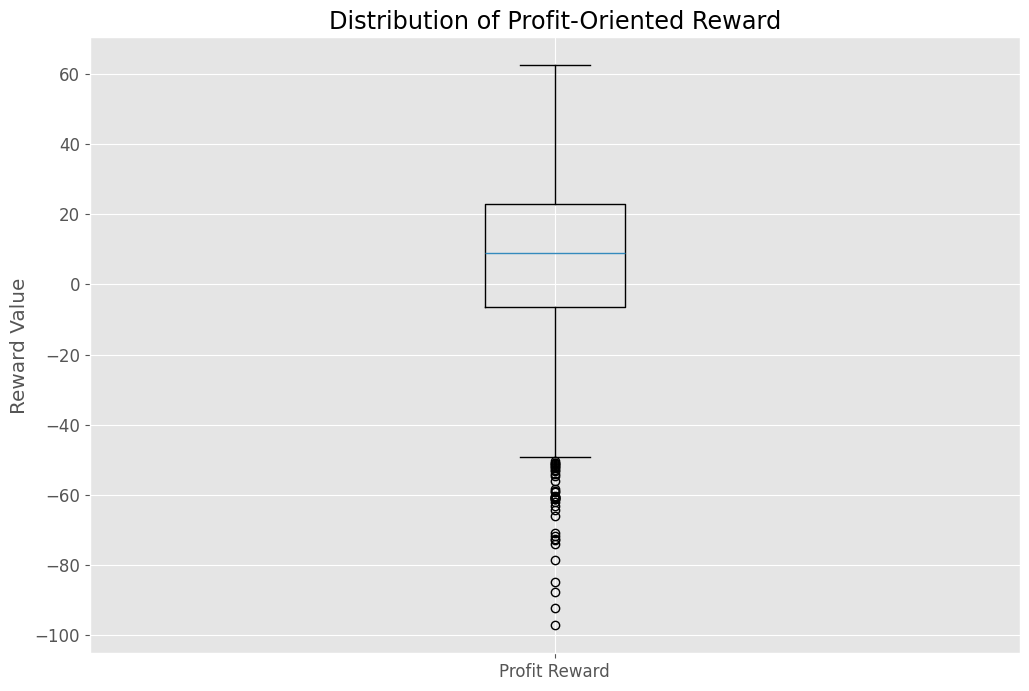

In [8]:
# Since we're only using profit_oriented_reward for this notebook,
# this visualization is provided just as a reference

# Compare the distributions of different reward functions
reward_data = train_df[['reward']]  # Only using profit_reward

plt.figure(figsize=(12, 8))
plt.boxplot(reward_data.values)
plt.title('Distribution of Profit-Oriented Reward')
plt.ylabel('Reward Value')
plt.xticks([1], ['Profit Reward'])
plt.grid(True)
plt.show()

## Training with Pi_Optimal

Now we'll use the data and reward functions to train Pi_Optimal agents. We'll train four different agents, each optimizing for a different reward function.

### Dataset Preparation

First, we need to prepare the dataset for Pi_Optimal.

In [9]:
# Define the state, action, and reward columns
state_columns = [
    'day_of_week',           # Day of the week affects demand patterns
    'total_inventory',       # Current total inventory
    'waste',                 # Recent waste
    'stockouts',             # Recent stockouts
    'demand'                 # Recent demand
]

action_columns = ['order_quantity']

lookback = 7 # Number of days to look back for state features 
reward_column = 'reward' 

train_dataset = po.datasets.timeseries_dataset.TimeseriesDataset(
    df=train_df,        
    lookback_timesteps=lookback,
    unit_index='episode',         # Each episode is a separate unit
    timestep_column='day',        # Day is our timestep
    reward_column=reward_column,  # Use the specified reward
    state_columns=state_columns,  # State features
    action_columns=action_columns # Action features
)

### Agent Configuration

Now we'll set up the Pi_Optimal agent with appropriate model configurations.

In [10]:
# Define the model configuration
model_config = [
    {
        "model_type": "RandomForest",
        "params": {
            "n_estimators": 100,
            "max_depth": None
        }
    },
    {
        "model_type": "RandomForest",
        "params": {
            "n_estimators": 100,
            "max_depth": None
        }
    }
]

### Training the Agent

Now we'll train agents for each reward function.

In [11]:
from pi_optimal.agents.agent import Agent


agent = Agent()
agent.train(train_dataset, model_config=model_config)


Training models...:   0%|          | 0/6 [00:00<?, ?it/s]

Training models...:   0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
# Save the agents for future use
agent.save(path='agents/profit_agent')
# waste_agent.save(path='agents/waste_agent')
# stockout_agent.save(path='agents/stockout_agent')
# balanced_agent.save(path='agents/balanced_agent')

## Evaluating Performance

Now let's evaluate how well each agent performs in the environment.

In [14]:
# apply reward functions to test data
test_data['reward'] = test_data.apply(profit_oriented_reward, axis=1)

current_dataset = po.datasets.timeseries_dataset.TimeseriesDataset(
                                    df=test_data,
                                    dataset_config=agent.dataset_config,
                                    train_processors=False,
                                    is_inference=True
)

In [15]:
best_actions = agent.predict(current_dataset, 
                             horizon=6)

Simulating trajectories:   0%|          | 0/6 [00:00<?, ?it/s]

Simulating trajectories:   0%|          | 0/6 [00:00<?, ?it/s]

Simulating trajectories:   0%|          | 0/6 [00:00<?, ?it/s]

Simulating trajectories:   0%|          | 0/6 [00:00<?, ?it/s]

Simulating trajectories:   0%|          | 0/6 [00:00<?, ?it/s]

Simulating trajectories:   0%|          | 0/6 [00:00<?, ?it/s]

Simulating trajectories:   0%|          | 0/6 [00:00<?, ?it/s]

Simulating trajectories:   0%|          | 0/6 [00:00<?, ?it/s]

Simulating trajectories:   0%|          | 0/6 [00:00<?, ?it/s]

Simulating trajectories:   0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
for i in range(len(best_actions)):
    print(f"Timestep {i}:")    
    print("Profit reward:", round(test_data['profit_reward'].iloc[i], 2))
    print("Number of orders:", best_actions[i][0])
    print()
    print("--------------------")
    print()

Timestep 0:
Profit reward: 8.2
Number of orders: 15.555851671963019

--------------------

Timestep 1:
Profit reward: 29.2
Number of orders: 12.104041658126498

--------------------

Timestep 2:
Profit reward: 34.6
Number of orders: 15.416506635434235

--------------------

Timestep 3:
Profit reward: -18.8
Number of orders: 12.270321287342696

--------------------

Timestep 4:
Profit reward: 49.6
Number of orders: 10.959342946614578

--------------------

Timestep 5:
Profit reward: 30.6
Number of orders: 3.3442009246340643

--------------------



In [17]:
from pi_optimal.utils.trajectory_visualizer import TrajectoryVisualizer

trajectory_visualizer = TrajectoryVisualizer(agent, current_dataset, best_actions=best_actions)
trajectory_visualizer.display()

Simulating trajectories:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# Evaluate Model Performance
from pi_optimal.evaluators.base_evaluator import BaseEvaluator
from pi_optimal.evaluators.plotting import plot_n_step_evaluation

# Initialize the evaluator with the dataset configuration
evaluator = BaseEvaluator(dataset_config=agent.dataset_config)

eval_results = evaluator.evaluate_dataset(test_data, agent.models[0], n_steps=10)

# Plot the n-step evaluation results
# plot_n_step_evaluation(evaluations, test_data)